In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from myIO import gen_from_data
from glob import glob
from densenet import DenseNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Merge, Dense, Dropout, merge, Reshape, Dropout
from keras.layers import LSTM, Lambda, TimeDistributed, Activation, RepeatVector, Permute, Masking
from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam
from utils import show_losses, plot_confusion_matrix
from sklearn.metrics import confusion_matrix

### Checkout the training dataset

In [4]:
nb_train = glob('/data/shared/Delphes/np_samples_new/3_way/MaxLepDeltaR_des/train/images/*.h5')
# Check the files
for trainfile in nb_train:
    f = h5py.File(trainfile)
    #print (trainfile)
    if len(f.keys()) < 2:
        print ("{} has unusual list of keys {}".format(trainfile,f.keys()))
        nb_train.remove(trainfile)
    f.close()

### Look at a random file, check quality and get the number of samples

[u'Images', u'Labels']
(750, 500, 314, 3)
[0 0 1]


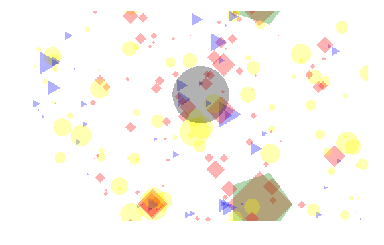

Number of samples = 93000
Number of validation = 17250
Number of test = 12000


In [5]:
f = h5py.File('/data/shared/Delphes/np_samples_new/3_way/MaxLepDeltaR_des/train/images/023_0.h5')
print (f.keys())
print (f['Images'].shape)
print (f['Labels'][0])
for ie in range(1):
    plt.imshow(f['Images'][ie,:,:,:].swapaxes(0,1),)
    plt.axis('off')
    plt.show()
NB_SAMPLES = len(nb_train)*f['Images'].shape[0]
print ("Number of samples = {}".format(NB_SAMPLES))
nb_val = glob('/data/shared/Delphes/np_samples_new/3_way/MaxLepDeltaR_des/val/images/*.h5')
NB_VALS = len(nb_val)*f['Images'].shape[0]
nb_test = glob('/data/shared/Delphes/np_testsets_new/3_way/MaxLepDeltaR_des/val/images/*.h5')
NB_TESTS = len(nb_test)*f['Images'].shape[0]
print ("Number of validation = {}".format(NB_VALS))
print ("Number of test = {}".format(NB_TESTS))
f.close()

### Initialize the model, note to change the learning rate here

In [6]:
densenet = DenseNet(nb_classes = 3, img_dim = (500, 314, 3), depth = 10, nb_dense_block = 2, growth_rate = 3, 
                    dropout_rate= 0.5, nb_filter = 12)
densenet.summary()
optimizer = Adam(lr=1e-5)
densenet.compile(loss = 'categorical_crossentropy' ,optimizer=optimizer,metrics=['accuracy'])
ms = densenet.to_json()
open('mpi_learn/densenet16_dropout0p5_elu.json','w').write(ms)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 500, 314, 3)   0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 3, 500, 314)   0           input_1[0][0]                    
____________________________________________________________________________________________________
initial_conv2D (Convolution2D)   (None, 12, 500, 314)  324         permute_1[0][0]                  
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 12, 500, 314)  48          initial_conv2D[0][0]             
___________________________________________________________________________________________

### Start training

In [7]:
#checkpoint = ModelCheckpoint(filepath='CheckPoints/DenseNet10_Dropout0p5_BestWeight_LR1e-5.h5', 
checkpoint = ModelCheckpoint(filepath='CheckPoints/test.h5', 
                             monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

BATCH_SIZE = 10
training_generator = gen_from_data('/data/shared/Delphes/np_samples_new/3_way/MaxLepDeltaR_des/train/images/',
                                   #prep_func = normalize,
                                   batch_size=BATCH_SIZE,data_keys=["Images","Labels"])
validation_generator = gen_from_data('/data/shared/Delphes/np_samples_new/3_way/MaxLepDeltaR_des/val/images/',
                                     #prep_func = normalize,
                                     batch_size=BATCH_SIZE,data_keys=["Images","Labels"])


densenet.load_weights('CheckPoints/DenseNet10_Dropout0p5_BestWeight_LR1e-4.h5')
history = densenet.fit_generator(generator = training_generator,
                        samples_per_epoch = 1000,
                        #samples_per_epoch = NB_SAMPLES/BATCH_SIZE,
                        validation_data = validation_generator,
                        nb_val_samples = 100,
                        #nb_val_samples = NB_VALS/BATCH_SIZE,
                        nb_epoch = 5,
                        verbose = 1,
                        callbacks=[checkpoint]
                    )

Epoch 1/5
1000/1000 [==============================] - 17s - loss: 0.5189 - acc: 0.8170 - val_loss: 0.5291 - val_acc: 0.7800
Epoch 2/5
1000/1000 [==============================] - 16s - loss: 0.5307 - acc: 0.7860 - val_loss: 0.5411 - val_acc: 0.7900
Epoch 3/5
1000/1000 [==============================] - 16s - loss: 0.5650 - acc: 0.7710 - val_loss: 0.5562 - val_acc: 0.7400
Epoch 4/5
1000/1000 [==============================] - 16s - loss: 0.6039 - acc: 0.7600 - val_loss: 0.4956 - val_acc: 0.7800
Epoch 5/5
1000/1000 [==============================] - 16s - loss: 0.5609 - acc: 0.7820 - val_loss: 0.5527 - val_acc: 0.7600


### Load the best model and evaluate on the test set

In [8]:
from keras.models import load_model
model = load_model('CheckPoints/DenseNet10_Dropout0p5_BestWeight_LR1e-5.h5')
eval_generator = gen_from_data('/data/shared/Delphes/np_testsets_new/3_way/MaxLepDeltaR_des/val/images/',
                                     #prep_func = normalize,
                                     batch_size=BATCH_SIZE,data_keys=["Images","Labels"])
results = model.evaluate_generator(eval_generator, val_samples = NB_TESTS/BATCH_SIZE)
print ("Result: Loss = {}, Acc = {}".format(results[0], results[1]))

test_set = glob('/data/shared/Delphes/np_testsets_new/3_way/MaxLepDeltaR_des/val/images/*_*.h5')
confu_matrix = np.zeros((3,3))
for i,test in enumerate(test_set):
    #test = test_set[0]
    f = h5py.File(test,'r')
    prob = model.predict(f['Images'])
    pred = np.argmax(prob, axis = 1)
    truth = np.argmax(f['Labels'], axis = 1)
    if i == 0:
        prob_all = np.copy(prob)
        truth_all= np.copy(f['Labels'])
    else:
        prob_all = np.vstack((prob_all, prob))
        truth_all = np.vstack((truth_all, f['Labels']))
            
    confu_matrix += confusion_matrix(truth,pred)
    f.close()

Result: Loss = 0.460251202683, Acc = 0.824166662494


## Make confusion matrix and ROC curve

Confusion matrix, without normalization
[[ 3095.   222.   748.]
 [  305.  3490.   195.]
 [  671.   128.  3146.]]
Normalized confusion matrix
[[ 0.76137761  0.05461255  0.18400984]
 [ 0.0764411   0.87468672  0.04887218]
 [ 0.17008872  0.03244613  0.79746515]]


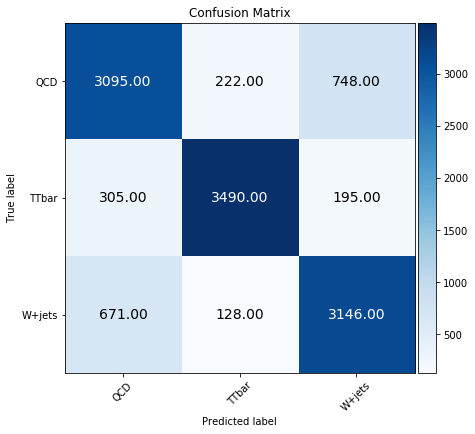

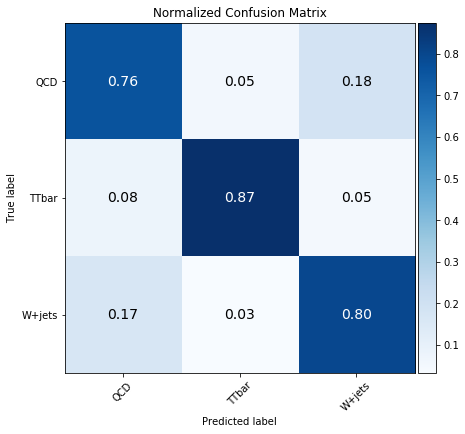

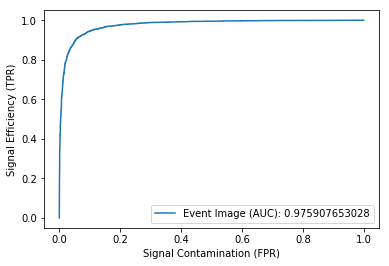

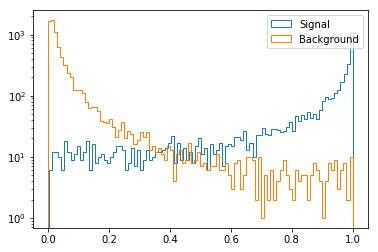

In [10]:
# Make confusion matrix
plot_confusion_matrix(confu_matrix,['QCD','TTbar','W+jets'],title='Confusion Matrix')
plot_confusion_matrix(confu_matrix,['QCD','TTbar','W+jets'],normalize=True,title='Normalized Confusion Matrix')

# Make ROC curve
prob_signal = np.zeros(shape=(prob_all.shape[0],1))
prob_signal[:,0] = prob_all[:,1]
truth_signal = np.copy(truth_all[:,1])
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(truth_signal, prob_signal)
area = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,tpr,label="Event Image (AUC): {}".format(area))
plt.ylabel('Signal Efficiency (TPR)')
plt.xlabel('Signal Contamination (FPR)')
plt.legend(loc='best')
plt.show()

with h5py.File("EventImage_ROC.h5","w") as roc_file:
    roc_file.create_dataset("FPR", data=fpr)
    roc_file.create_dataset("TPR", data=tpr)

# Make signal vs. background distribution
plt.figure
sn_prob = prob_signal[np.where(truth_signal > 0.5)]
bkg_prob = prob_signal[np.where(truth_signal < 0.5)]
plt.hist(sn_prob, histtype='step', bins=100, label='Signal')
plt.hist(bkg_prob, histtype='step', bins=100, label='Background')
plt.legend(loc='best')
plt.yscale('log')
plt.show()

ValueError: Not a file id (Not a file id)

### Make ROC curve
Take signal as [0 1 0], the rest as background

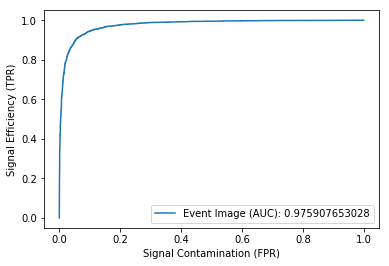

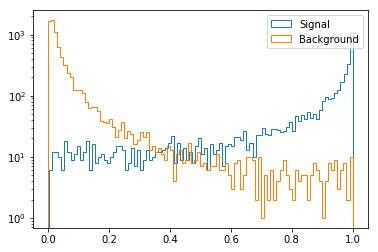